# Model Ekstraksi dan Pemurnian Bijih Emas

# 1 Deskripsi Proyek

## Tujuan Proyek

Membuat Model untuk yang dapat memprediksi jumlah emas yang diekstrasi atau diperoleh dari bijih emas. Model ini diharapkan akan membantu terciptanya proses produksi yang lebih efisien dan menyingkirkan parameter-parameter yang tidak menghasilkan keuntungan.

## Informasi Dataset

* gold_recovery_train.csv
* gold_recovery_test.csv
* gold_recovery_full.csv

Sebagian parameter tidak tersedia karena pengukuran dan/atau penghitungannya dilakukan jauh setelahnya. Itulah sebabnya, beberapa fitur yang ada di training set mungkin tidak ada di test set. Test set-nya pun juga tidak memuat target.
Dataset sumber memuat training dan test set dengan semua fitur-fiturnya.

Nilai yang diprediksi sebagai target:
1. Perolehan konsentrat yang lebih kasar `rougher.output.recovery`
2. Perolehan konsentrat akhir `final.output.recovery`

## Proses Ekstraksi
Bijih yang ditambang mengalami pemrosesan primer untuk mendapatkan campuran bijih atau umpan (feed) yang lebih kasar. Hasil dari proses itu digunakan sebagai bahan baku untuk flotasi (alias proses untuk menghasilkan konsentrat yang lebih kasar). Setelah dilakukan flotasi, hasil partikel-partikelnya pun melewati proses pemurnian dua tahap.

## Deskripsi Data

**Proses Teknologi**
* Rougher feed — bahan mentah untuk proses flotasi
* Rougher additions (atau reagent additions) — reagen untuk flotasi: Xanthate, * Sulphate, Depressant
* Xanthate — penggerak atau aktivator flotasi
* Sulphate — natrium sulfida, khusus untuk proses ini
* Depressant — natrium silikat
* Rougher process — flotasi
* Rougher tails — residu produk
* Float banks — unit flotasi
* Cleaner process — pemurnian
* Rougher Au — konsentrat emas yang lebih kasar
* Final Au — konsentrat emas akhir

**Parameter dari Tahap-Tahap yang Tersedia**
* air amount — volume udara
* fluid levels
* feed size — ukuran partikel umpan
* feed rate

**Penamaan Fitur**
Berikut merupakan cara untuk memberikan nama pada fitur-fitur yang ada:

`[stage].[parameter_type].[parameter_name]`

Contoh: `rougher.input.feed_ag`

Nilai yang memungkinkan untuk [stage]:
* rougher — flotasi
* primary_cleaner — pemurnian pertama
* secondary_cleaner — pemurnian kedua
* final — karakteristik akhir

Nilai yang memungkinkan untuk [parameter_type]:
* input — parameter bahan mentah
* output — parameter produk
* state — parameter yang menunjukkan karakteristik tahapan saat ini
* calculation — perhitungan karakteristik

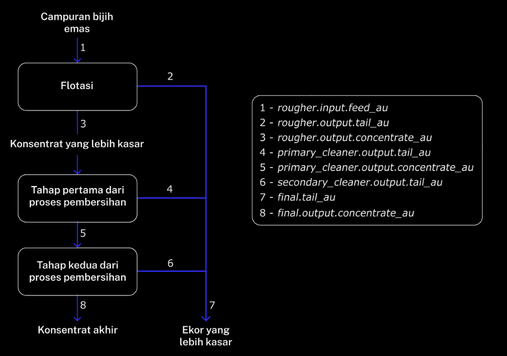

In [144]:
# Load Library
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

pd.set_option('display.max_rows', None, 'display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed

import sys
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# 2 Ikhtisar Data

## 2.1 Seputar Data

In [145]:
# Menyiapkan dataset
train = pd.read_csv('/content/gold_recovery_train.csv') # Dataset train
test = pd.read_csv('/content/gold_recovery_test.csv') # Dataset test
full = pd.read_csv('/content/gold_recovery_full.csv') # Dataset sumber

In [146]:
# Menampilkan sample dari dataset train
print('\033[1;34mDataset train\033[0m')
display(train.head())
display(train.tail())

Dataset train


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
16855,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,8.028927,6.5,1.304232,6.559174,12.445966,7.056338,32.940215,22.854592,6.531541,3.934320,2.314352,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,1648.833984,-399.669220,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069,11.124896,10.984003,30.068876,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,1199.245914,-300.845518,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664,0.0,0.0,0.0,0.0,35.043205,-499.045671,29.906659,-499.979939,26.002402,-499.953431,22.987238,-499.967351,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,7.962636,6.5,1.302419,6.612376,12.623947,7.542264,32.

In [147]:
# Menampilkan sample dari dataset test
print('\033[1;34mDataset test\033[0m')
display(test.head())
display(test.tail())

Dataset test


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5851,2017-12-31 19:59:59,173.957757,15.963399,8.07,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,1400.334792,-499.243459,11.638973,4.695306,521.685155,66.758479,42.022027,10.554544,10.109194,7.203935,10.110793,7.198171,1399.935264,-299.999637,1049.641991,-500.074887,951.923857,-499.648793,852.337438,-498.464443,851.436769,-500.285584,851.461345,-499.735650,21.912132,-499.915179,19.909080,-499.734909,24.939573,-500.098479,12.968448,-499.952023,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,2017-12-31 20:59:59,172.910270,16.002605,8.07,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,1447.653388,-480.403849,11.338091,4.478381,530.195798,62.560684,41.096377,10.254051,9.979495,7.200895,9.978855,7.201957,1406.122319,-299.057200,1055.715243,-498.250207,956.850266,-497.403941,855.386714,-495.702676,852.071335,-499.442753,851.328986,-496.579809,25.322301,-497.034975,23.310568,-498.892647,26.369171,-499.222375,17.704862,-499.545681,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,2017-12-31 21:59:59,171.135718,15.993669,8.07,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,1502.585343,-498.260225,11.285908,4.405327,546.306868,73.647513,41.095485,10.169094,10.182219,7.196255,10.185461,7.198676,1396.203070,-300.210722,1047.879742,-499.604248,948.963429,-499.549567,856.325597,-500.095616,850.614597,-499.473713,850.279578,-498.508374,29.075948,-500.528402,26.888005,-500.975799,28.000224,-500.565876,22.996528,-500.477583,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,1502.688918,-501.569723,11.289710,4.343488,547.331405,78.066446,41.715740,10.071156,10.730915,7.200058,10.726349,7.200834,1403.942288,-300.030119,1049.802289,-499.795576,950.769390,-500.374645,847.647198,-499.920332,849.413

In [148]:
# Menampilkan sample dari dataset ketiga
print('\033[1;34mDataset full\033[0m')
display(full.head())
display(full.tail())

Dataset full


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,8.028927,6.5,1.304232,6.559174,12.445966,7.056338,32.940215,22.854592,6.531541,3.934320,2.314352,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,1648.833984,-399.669220,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069,11.124896,10.984003,30.068876,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,1199.245914,-300.845518,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664,0.0,0.0,0.0,0.0,35.043205,-499.045671,29.906659,-499.979939,26.002402,-499.953431,22.987238,-499.967351,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,7.962636,6.5,1.302419,6.612376,12.623947,7.542264,32.

In [149]:
# Fungsi untuk menampilkan informasi umum dari dataset
def nilai_nol(data):
  nilai_0 = (data == 0).sum(axis=0) 
  return nilai_0

def cek_duplikat(data):
  duplikat = data.duplicated().sum()
  if duplikat > 0:
    print("\033[1;34m" + 'Terdapat baris duplikat sebanyak {}'.format(duplikat) + "\033[0m")
  else:
    print('\033[1;34mTidak ada baris duplikat\033[0m')     

def seputar_data(data):
  total_row = len(data)
  total_na = data.isna().sum()
  persentase_na = round((total_na / total_row) * 100,2)
  byk_nilai = data.count()
  tipe = data.dtypes
  nilai_0 = nilai_nol(data)
  persentase_nilai_0 = round((nilai_0 / total_row) * 100,2)

  info_data = pd.DataFrame({
      'tipe' : tipe,
      'byk_nilai' : byk_nilai,
      'na' : total_na,
      'na%' : persentase_na,
      'nilai_nol' : nilai_0,
      'nol%' : persentase_nilai_0
  })
  display(info_data)  
  print()
  print(cek_duplikat(data))
  print()
  print(data.shape)

In [150]:
# Menjalankan fungsi untuk menampilkan informasi umum dari dataset train
print('\033[1;34mInformasi Umum pada Dataset train\033[0m')
seputar_data(train)

Informasi Umum pada Dataset train


,tipe,byk_nilai,na,na%,nilai_nol,nol%
date,object,16860,0,0.00,0,0.00
final.output.concentrate_ag,float64,16788,72,0.43,1263,7.49
final.output.concentrate_pb,float64,16788,72,0.43,1263,7.49
final.output.concentrate_sol,float64,16490,370,2.19,1263,7.49
final.output.concentrate_au,float64,16789,71,0.42,1263,7.49
final.output.recovery,float64,15339,1521,9.02,89,0.53
final.output.tail_ag,float64,16794,66,0.39,1658,9.83
final.output.tail_pb,float64,16677,183,1.09,1658,9.83
final.output.tail_sol,float64,16715,145,0.86,1658,9.83
final.output.tail_au,float64,16794,66,0.39,1658,9.83



Tidak ada baris duplikat
None

(16860, 87)


In [151]:
# Menjalankan fungsi untuk menampilkan informasi umum dari dataset test
print('\033[1;34mInformasi Umum pada Dataset test\033[0m')
seputar_data(test)

Informasi Umum pada Dataset test


,tipe,byk_nilai,na,na%,nilai_nol,nol%
date,object,5856,0,0.00,0,0.00
primary_cleaner.input.sulfate,float64,5554,302,5.16,0,0.00
primary_cleaner.input.depressant,float64,5572,284,4.85,0,0.00
primary_cleaner.input.feed_size,float64,5856,0,0.00,0,0.00
primary_cleaner.input.xanthate,float64,5690,166,2.83,0,0.00
primary_cleaner.state.floatbank8_a_air,float64,5840,16,0.27,93,1.59
primary_cleaner.state.floatbank8_a_level,float64,5840,16,0.27,0,0.00
primary_cleaner.state.floatbank8_b_air,float64,5840,16,0.27,88,1.50
primary_cleaner.state.floatbank8_b_level,float64,5840,16,0.27,0,0.00
primary_cleaner.state.floatbank8_c_air,float64,5840,16,0.27,48,0.82



Tidak ada baris duplikat
None

(5856, 53)


In [152]:
# Menjalankan fungsi untuk menampilkan informasi umum dari dataset full
print('\033[1;34mInformasi Umum pada Dataset full\033[0m')
seputar_data(full)

Informasi Umum pada Dataset full


,tipe,byk_nilai,na,na%,nilai_nol,nol%
date,object,22716,0,0.00,0,0.00
final.output.concentrate_ag,float64,22627,89,0.39,1613,7.10
final.output.concentrate_pb,float64,22629,87,0.38,1613,7.10
final.output.concentrate_sol,float64,22331,385,1.69,1613,7.10
final.output.concentrate_au,float64,22630,86,0.38,1613,7.10
final.output.recovery,float64,20753,1963,8.64,151,0.66
final.output.tail_ag,float64,22633,83,0.37,1950,8.58
final.output.tail_pb,float64,22516,200,0.88,1950,8.58
final.output.tail_sol,float64,22445,271,1.19,1950,8.58
final.output.tail_au,float64,22635,81,0.36,1950,8.58



Tidak ada baris duplikat
None

(22716, 87)


## 2.2 Kesimpulan Sementara


In [153]:
# Menampilkan kembali data shape pada ketiga dataframe
print('Ukuran baris dan kolom dataset train :', train.shape)
print('Ukuran baris dan kolom dataset test :', test.shape)
print('Ukuran baris dan kolom dataset full :', full.shape)

Ukuran baris dan kolom dataset train : (16860, 87)
Ukuran baris dan kolom dataset test : (5856, 53)
Ukuran baris dan kolom dataset full : (22716, 87)


Berikut ini kesimpulan sementara dari informasi umum dataset:
1. Sesuai dengan informasi awal tentang data set ada perbedaan fitur antara data train dan data test. 

2. Jumlah kolom pada data train sama dengan jumlah kolom pada data full (sumber) yaitu 87 kolom, tetapi hanya 53 kolom pada data test. Berarti ada fitur yang tidak ada pada dataset.

3. Ada 16860 baris pada data train dan 5856 baris pada data test yang merupakan jumlah dari keseluruhan data full : 22716. Berarti data set menggunakan sekitar 26% dari data keseluruhan.

4. Target yang akan diprediksi adalah `rougher.output.recovery` dan `final.output.recovery`. Kedua target ada di train set tetapi tidak ada di test set.

5. Semua tipedata berupa float kecuali `date` berupa object, yang sebaiknya diubah ke format datetime.

6. Data yang hilang dan data yang bernilai 0 tersebar di kolom-kolom ketiga dataset, yang jumlahnya relatif kecil.

7. Tidak ada baris duplikat pada ketiga dataset


# 3 Pra-pemrosesan Data

## 3.1 Formula Perolehan

**Perhitungan untuk Perolehan**

> `Perolehan = ((C * (F-T)) / (F * (C-T))) * 100%`

Dengan:
* C — persentase emas dalam konsentrat tepat setelah proses flotasi (untuk menemukan perolehan konsentrat yang lebih kasar)/setelah dilakukan pemurnian (untuk menemukan perolehan konsentrat akhir)
* F — persentase emas dalam umpan (feed) sebelum proses flotasi (untuk menemukan perolehan konsentrat yang lebih kasar)/ dalam konsentrat tepat setelah proses flotasi (untuk menemukan perolehan konsentrat akhir)
* T — persentase emas dalam ekor yang lebih kasar, tepat setelah proses flotasi (untuk menemukan perolehan konsentrat yang lebih kasar)/setelah dilakukan pemurnian (untuk menemukan perolehan konsentrat akhir)

## 3.2 Memeriksa Perolehan Emas pada `training set`

Data perolehan emas ada pada kolom `rougher.output.recovery` di train set. Nilai ini akan diuji dengan formula yang telah diberikan.

In [154]:
# Memeriksa perolehan emas pada training set
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

# Kalkulasi perolehan emas dengan perhitungan dan membuat kolom 'kalkulasi_perolehan'
train['kalkulasi_perolehan'] = ((C * (F-T)) / (F * (C-T))) * 100

# Membandingkan data perolehan 'kalkulasi_perolehan' dengan data yang sudah ada pada train set 'rougher.output.recovery'
train[['kalkulasi_perolehan', 'rougher.output.recovery']][0:5]

,kalkulasi_perolehan,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


5 baris pertama bernilai sama, untuk memastikan data keseluruhan diperlukan pehitungan MAE

In [155]:
MAE = (train['kalkulasi_perolehan'] - train['rougher.output.recovery']).abs().mean()
MAE

9.303415616264301e-15

Nilai MAE sangat kecil atau mendekati 0, maka perhitungan 'rougher.output.recovery' adalah benar

## 3.3 Kolom yang hilang pada test set

In [156]:
# Menampilkan kolom yang ada pada test set
fitur_test = list(set(test.columns))
sorted(fitur_test)

['date',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

In [157]:
# Mencari kolom (fitur) yang tidak ada pada test set
kolom_hilang = list(set(train.columns)-set(test.columns))
sorted(kolom_hilang)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'kalkulasi_perolehan',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_

Analisis kolom yang hilang:
1. Jika diperhatikan kolom yang hilang pada `train set` memiliki kata output dan calculation. Sesuai dengan deskripsi data diatas kolom-kolom yang hilang memiliki `tipe parameter` `input` dan `calculation`. Data output merupakan **parameter produk** dan calculation berarti **perhitungan karakteristik**. Kolom ini merupakan keterangan yang secara langsung mendeskripsikan hasil dan tidak menentukan hasil prediksi.

2. Kolom yang terdapat pada `test set` merupakan `input` (parameter bahan mentah) atau `state`(parameter yang menunjukan karakteristik tahapan) yang merupakan parameter/fitur yang dapat mempengaruhi hasil ekstraksi emas. Kolom ini sangat diperlukan dan akan digunakan sebagai fitur pada `model`.

3. Karena fitur-fitur yang hilang itu tidak diperlukan pada model, maka fitur-fitur ini dihapus dari `train set` pada tahap berikutnya. Pada akhirnya jumlah fitur pada `train set` sama dengan `test set`.

## 3.4 Nilai yang hilang

In [158]:
# Persentase rata-rata nilai yang hilang dari setiap kolom pada train set
print(round(train.isna().sum().mean()/len(train),2)*100, '% rata-rata nilai yang hilang')

2.0 % rata-rata nilai yang hilang


In [159]:
# Persentase rata-rata nilai yang hilang dari setiap kolom pada test set
print(round(test.isna().sum().mean()/len(test),2)*100, '% rata-rata nilai yang hilang')

1.0 % rata-rata nilai yang hilang


Seperti temuan pada bagian ikhtisar data, ada sedikit nilai yang hilang pada hampir semua kolom pada kedua dataset, jumlah nilai yang hilang sekitar 2 % dan 1% per kolom untuk train set dan test set. Baris-baris ini dapat dihapus.

In [160]:
# Menghapus baris dengan nilai yang hilang pada kedua dataset
train = train.dropna(how='any', axis=0)
train.reset_index(drop=True, inplace=True)

test = test.dropna(how='any', axis=0)
test.reset_index(drop=True, inplace=True)

In [161]:
# Memeriksa kembali nilai yang hilang pada kedua dataset
print('Jumlah nilai yang hilang pada train set',train.isna().sum().sum())
print('Jumlah nilai yang hilang pada train set',test.isna().sum().sum())

Jumlah nilai yang hilang pada train set 0
Jumlah nilai yang hilang pada train set 0


## 3.5 Mengubah tipe data pada kolom date

In [162]:
# Mengubah tipe data pada kolom `date` dari object menjadi datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
full['date'] = pd.to_datetime(full['date'])

In [163]:
# Memeriksa tipe data pada kolom `date` di ketiga dataset
print('Tipe data untuk train set adalah',train['date'].dtype)
print('Tipe data untuk test set adalah',test['date'].dtype)
print('Tipe data untuk full set adalah',test['date'].dtype)

Tipe data untuk train set adalah datetime64[ns]
Tipe data untuk test set adalah datetime64[ns]
Tipe data untuk full set adalah datetime64[ns]


# 4 Analisis Data Eksploratif (EDA)

## 4.1 Perubahan Konsentrasi Logam (Au, Ag, Pb) pada setiap Tahap

Logam yang terkandung pada proses ekstraksi adalah: Au, Ag, Pb.

Dari Deskripsi Proyek, ada 3 tahapan `[stage]` ekstraksi emas, berikut 3 tahapan dan output yang dihasilkan:
1. Flotasi -> `rougher.output.concentrate`
2. Pemurnian Pertama -> `primary_cleaner.output.concentrate`
3. Pemurnian Kedua -> `final.output.concentrate`

Seperti yang diketahui sebelumnya bahwa `parameter` bertipe `output` hanya ada di `train set` maka, untuk analisis konsentrasi logam hanya dilakukan menggunakan `train set`.

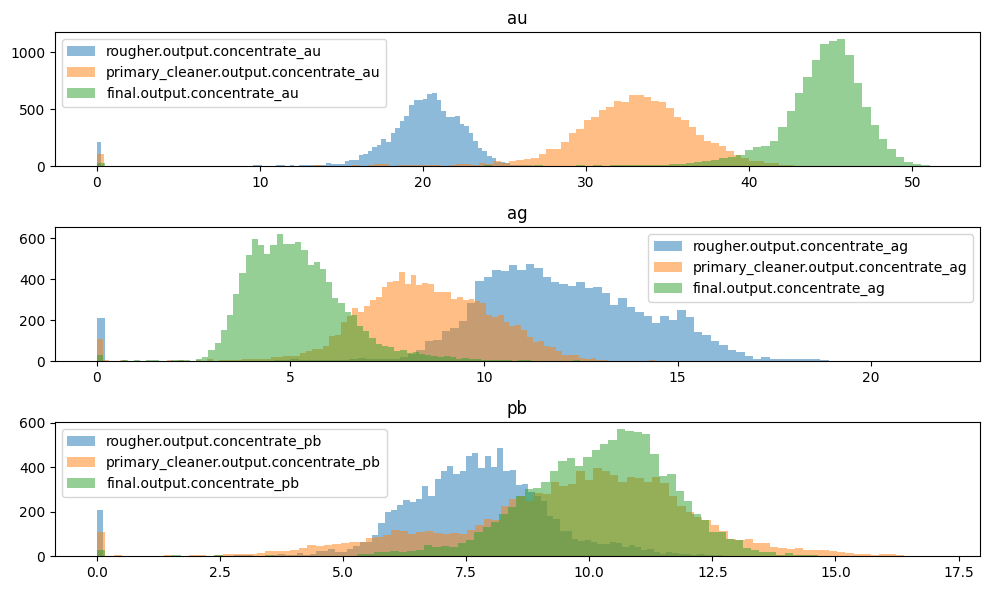


Konsentrasi rougher.output.concentrate_au 20
Konsentrasi primary_cleaner.output.concentrate_au 33
Konsentrasi final.output.concentrate_au 45
Konsentrasi rougher.output.concentrate_ag 12
Konsentrasi primary_cleaner.output.concentrate_ag 8
Konsentrasi final.output.concentrate_ag 5
Konsentrasi rougher.output.concentrate_pb 8
Konsentrasi primary_cleaner.output.concentrate_pb 10
Konsentrasi final.output.concentrate_pb 10


In [164]:
# Menampilkan grafik perubahan konsentrai logam pada setiap tahap
daftar_logam = ['au', 'ag', 'pb']
daftar_tahapan = ['rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
plt.figure(figsize=(10,6))

for i,logam in enumerate(daftar_logam):
    for tahapan in daftar_tahapan:
        plt.subplot(3,1,i+1) 
        plt.hist(train[tahapan+'_'+logam], bins=100, label=tahapan+'_'+logam,  alpha=.5);
    plt.title(logam)
    plt.legend()    
plt.tight_layout()
plt.show()

print()
# Data numerik pendukung grafik
for i,logam in enumerate(daftar_logam):
    for tahapan in daftar_tahapan:
        print('Konsentrasi {} {}'.format(tahapan+'_'+logam, round(train[tahapan+'_'+logam].median()),2))

1. Berikut ini perubahan konsentrasi emas (au) pada kedua tahap pemurnian:
> * Pemurnian Pertama : konsentrasi median 20% menjadi 33%
> * Pemurnian Kedua : Konsentrasi median 33% menjadi 44%.
> * Terjadi peningkatan konsentrasi emas pada kedua tahap pemurnian sampai 44%
2. Berikut ini perubahan konsentrasi perak (ag) pada kedua tahap pemurnian:
> * Pemurnian Pertama : konsentrasi median 11% menjadi 8%
> * Pemurnian Kedua : Konsentrasi median 8% menjadi 5%.
> * Berbeda dengan emas, kedua tahap pemurnian menyebakan penurunan konsentrasi perak sampai 5%.
3. Berikut ini perubahan konsentrasi timbal (pb) pada kedua tahap pemurnian:
> * Pemurnian Pertama : konsentrasi median 8% menjadi 10%
> * Pemurnian Kedua : konsentrasi median tetap pada 10%
> * Pemurnian kedua tidak berpengaruh terhadap konsentrasi timbal sehingga tetap 10% seperti pada pemurnian pertama.

## 4.2 Perbandingan Ukuran Partikel Umpan dalam `training set` dan `test set`

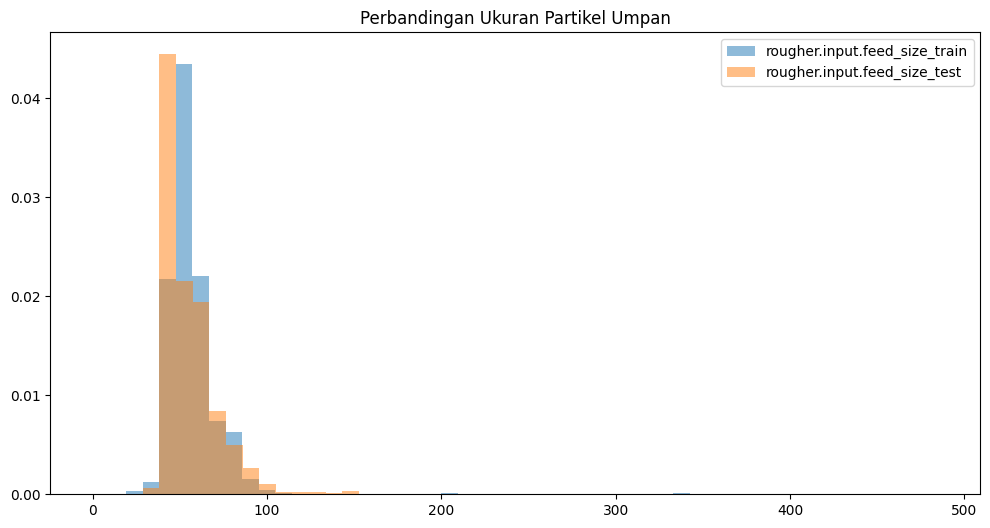

In [165]:
# Grafik perbandingan ukukran partikel umpan dalam `training set` dan `test set`
plt.figure(figsize=(12,6))
plt.hist(train['rougher.input.feed_size'],bins=50,label='rougher.input.feed_size_train',alpha=.5, density=1)
plt.hist(test['rougher.input.feed_size'],bins=50,label='rougher.input.feed_size_test',alpha=.5, density=1)
plt.legend()
plt.title('Perbandingan Ukuran Partikel Umpan');

Distribusi kedua dataset tidak jauh berbeda, oleh karena itu kedua dataset ini dapat digunakan untuk pembuatan model.

## 4.3 Konsentrasi Logam secara Keseluruhan pada setiap Tahap

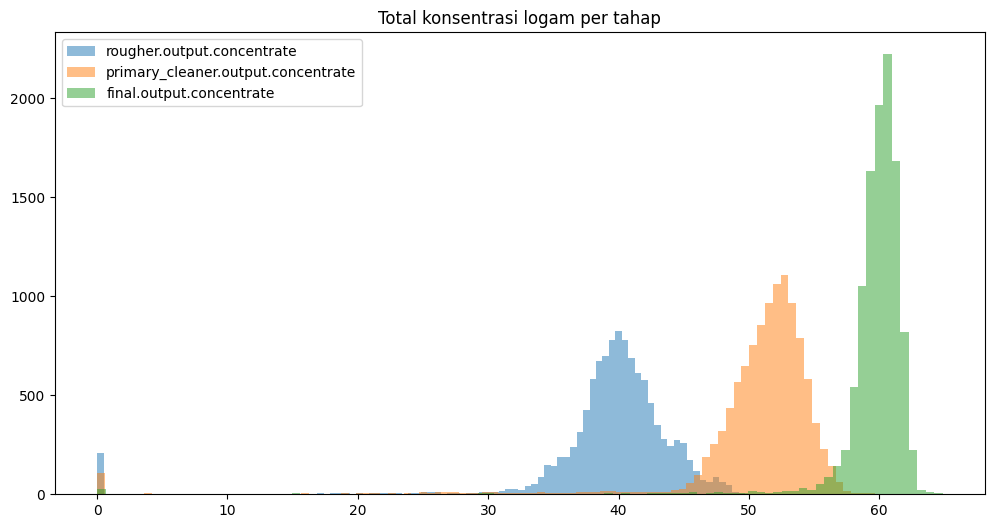

In [166]:
# Menampilkan grafik konsentrasi keseluruhan logam pada setiap tahap di `train set`
plt.figure(figsize=(12,6))
for tahap in daftar_tahapan:
    train[tahap+'semua_logam'] = 0
    for logam in daftar_logam:
        train[tahap+'semua_logam'] += train[tahap+'_'+logam]
    plt.hist(train[tahap+'semua_logam'], bins=100, label=tahap, alpha=.5)
    plt.title('Total konsentrasi logam per tahap')
    plt.legend();

Pada tahap sebelumnya nilai nan sudah dihapus pada `train set`, namun masih ada beberapa outlier untuk nilai disekitar 0 seperti yang terlihat pada grafik diatas. Langkah berikutnya nilai-nilai ini dihapus untuk menghilangkan outlier.

In [167]:
# Menghapus outlier di semua nilai konsentrasi logam pada setiap tahap
for i,logam in enumerate(daftar_logam):
    for tahap in daftar_tahapan:
        train[train[tahap+'_'+logam]<0.01] = np.nan
train = train.dropna(how='any', axis=0)

## 4.4 Analisis Target

`test set` tidak memiliki target, sehingga perlu diambil dari dataset sumber yaitu `full set`

In [168]:
# Menambahkan kolom target ke `test set`
test = test.merge(full[['date', 'final.output.recovery', 'rougher.output.recovery']], how='left', on='date')

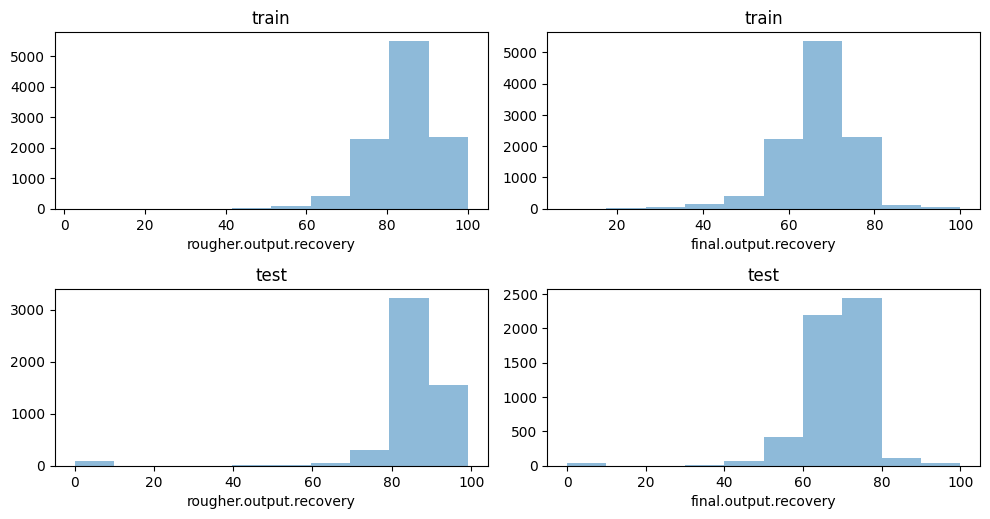

In [169]:
# Menampilkan histogram target untuk `train set` dan `test set`
target = ['rougher.output.recovery', 'final.output.recovery']
dts = [train, test]
train.name = 'train'
test.name = 'test'

plt.figure(figsize=(10,10))
c=1
for i, data in enumerate(dts):
    for tgt in target:
        plt.subplot(4,2,c)
        plt.hist(data[tgt], alpha=.5)
        plt.title(data.name)
        plt.xlabel(tgt)
        c = c + 1
plt.tight_layout()

Dari histogram di atas grafik `train set` sudah terlihat baik, sedangkan pada outlier terlihat setdikit outlier pada `test set`. Outlier ini akan dihapus untuk kedua target.

In [170]:
# Menghapus outlier target pada `test set`
for tgt in target:
    test[test[tgt]<0.01] = np.nan
    
test = test.dropna(how='any', axis=0)

In [171]:
# Menampilkan ukuran `test set`
print('Ukuran test set :',test.shape)

Ukuran test set : (5105, 55)


# 5 Pemodelan

## 5.1 Persiapan Dataset untuk Model

Sebelum pembuatan model, banyak fitur `train set` dan `test set` harus sama. Oleh karena itu jumlah kolom yang digunakan antar kedua dataset harus disamakan.

In [172]:
# Memfilter jumlah kolom `train set` sesuai kolom pada `test set` dengan dataset baru `train_filter`
kolom_sama =  list(set(train.columns).intersection(set(test.columns)))
train_filter = train[kolom_sama]

# Mengurutkan kolom `train_filter set` sehingga sama dengan urutan kolom `test set`
urutan_kolom = test.columns.tolist()
train_filter = train_filter.reindex(columns=urutan_kolom)

print('Ukuran train_filter set :',train_filter.shape)

Ukuran train_filter set : (10676, 55)


Saat ini ukuran dan urutan kolom dari dataset baru `train_filter set` telah sama dengan jumlah kolom dari `test set`, sehingga jumlah fitur dan targetnya juga akan sama.

## 5.2 Fitur dan Target dengan Standard Scaling

In [173]:
# Berikut ini langkah-langkah penentuan fitur dan target
fitur_train = train_filter.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
fitur_test =  test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_train = train_filter[['rougher.output.recovery', 'final.output.recovery']].values
target_test = test[['rougher.output.recovery', 'final.output.recovery']].values

# Penerapan Standard Scaling pada fitur
sc = StandardScaler()
fitur_train = sc.fit_transform(fitur_train)
fitur_test = sc.transform(fitur_test)

## 5.3 Formula Metrik Evaluasi

Untuk menyelesaikan masalah yang ada, kita akan memerlukan metrik yang baru. Metrik tersebut bernama sMAPE (symmetric Mean Absolute Percentage Error), atau kesalahan persentase absolut rata-rata simetris.
sMAPE mirip dengan MAE, hanya saja sMAPE diekspresikan dalam nilai relatif, bukan nilai absolut. Mengapa metrik ini disebut simetris? Karena sMAPE memperhitungkan skala target maupun prediksi.
Berikut adalah cara untuk menghitung sMAPE:

>`sMAPE = (1/n) * Σ (i=1 to N) ((|yi - ŷi| / (|yi| + |ŷi|)/2))*100`

* yi = Nilai target untuk observasi dengan indeks i dalam set yang digunakan untuk mengukur kualitas.
* ŷi = Nilai prediksi untuk observasi dengan indeks i, misalnya, dalam sampel * uji atau test sample.
* N = Jumlah observasi pada sampel.

Ada dua nilai yang akan diprediksi:
1. Perolehan konsentrat yang lebih kasar `rougher.output.recovery`
2. Perolehan konsentrat akhir `final.output.recovery`

> `sMAPE akhir = 25% * sMAPE(rougher) + 75% * sMAPE(final)`



In [174]:
# Fungsi menghitung sMAPE
def smape(target_true, target_pred):
    return (np.abs(target_true-target_pred)/((np.abs(target_true) + np.abs(target_pred))/2)).mean()

In [175]:
# Fungsi menghitung sMAPE akhir
def smape_akhir(target_true,target_pred):
    smape_rougher = smape(target_true[:,0], target_pred[:,0])
    smape_akhir = smape(target_true[:,1], target_pred[:,1])
    return 0.25*smape_rougher + 0.75*smape_akhir

## 5.4 Seleksi Model

Pada tahap ini, bebarapa model akan dijalankan dan dievaluasi menggunakan cross-validation.

In [176]:
# Menetapkan variabel untuk setiap model
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=12345)
rf = RandomForestRegressor(random_state=12345)

In [177]:
# Fungsi Cross-Validation
def crossval(model, fitur_train, target_train, cv):
    nilai_smape = make_scorer(smape_akhir)
    nilai_cross = cross_val_score(model, fitur_train, target_train, cv=cv, scoring=nilai_smape)
    return nilai_cross.mean()

In [178]:
# Menjalankan fungsi Cross-Validation
smape_akhir_lr = crossval(lr, fitur_train, target_train, 3)
smape_akhir_dt = crossval(dt, fitur_train, target_train, 3)
smape_akhir_rf = crossval(rf, fitur_train, target_train, 3)

In [179]:
# Membuat dataframe nilai smape untuk setiap model
smape_model = pd.DataFrame({
    'model': ['lr', 'dt', 'rf'],
    'smape': [smape_akhir_lr, smape_akhir_dt, smape_akhir_rf]})
smape_model = smape_model.sort_values(by='smape', ascending=False)

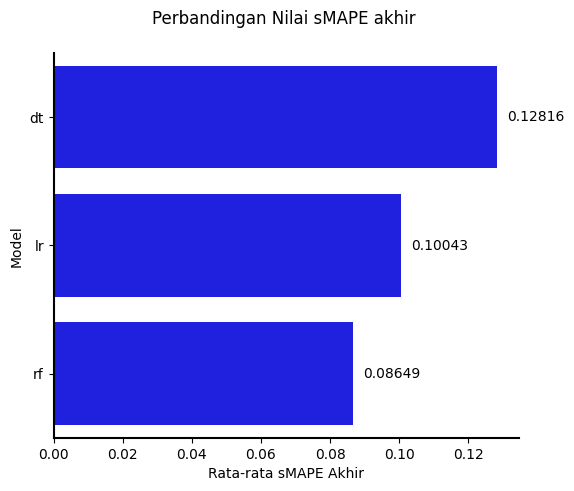

In [180]:
# Menampilkan grafik perbandingan nilai sMAPE akhir
plt.figure(figsize=(6, 5))
ax = sns.barplot(x='smape', y = 'model', data = smape_model, color = 'b')
plt.title('Perbandingan Nilai sMAPE akhir \n')
plt.xlabel('Rata-rata sMAPE Akhir')
plt.ylabel('Model')
for i, v in enumerate(smape_model['smape']):
    ax.text(v + 0.003, i, str(round(v,5)), color='black', va='center')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5) 
ax.spines['left'].set_linewidth(1.5)  
plt.show()

Random Forest model adalah memiliki nilai sMAPE rata-rata terbaik (terkecil) dengan nilai 0.08649.

## 5.5 Feature Importances

Feature Importance menggambarkan seberapa penting atau berpengaruhnya setiap fitur terhadap hasil prediksi atau pemodelan. Untuk mempersingkat waktu komputasi, model linear regression digunakan untuk mencari korelasi antara fitur dan target. Fitur-fitur dengan korelasi yang sangat kecil akan dihapus.

In [181]:
lr.fit(fitur_train, target_train)
korelasi = pd.DataFrame()
korelasi['fitur'] = train_filter.drop(['rougher.output.recovery','final.output.recovery','date'], axis=1).columns.values
korelasi['korelasi'] = pd.Series(lr.coef_[0])

korelasi.sort_values(by='korelasi', ascending=False)

,fitur,korelasi
32,rougher.state.floatbank10_f_air,2.873959
12,rougher.input.feed_ag,1.969526
25,rougher.state.floatbank10_b_level,1.882530
16,rougher.input.feed_sol,1.829609
23,rougher.state.floatbank10_a_level,1.695842
0,primary_cleaner.input.sulfate,1.635028
46,secondary_cleaner.state.floatbank5_a_air,1.521347
20,rougher.input.floatbank11_sulfate,1.245344
6,primary_cleaner.state.floatbank8_b_air,1.223162
38,secondary_cleaner.state.floatbank3_a_air,1.167750


Dari tabel diatas terlihat bahwa fitur `rougher.state.floatbank10_f_air` memiliki pengaruh yang terbesar terhadap target dari fitur lainnya. Fitur dengan nilai yang mendekati 0 tidak memiliki pengaruh yang signifikan terhadap target, akan dihapus.

In [182]:
# Fitur dengan korelasi yang baik
fitur_korelasi = korelasi.loc[abs(korelasi['korelasi']) > 0.1 , 'fitur']

In [183]:
# Filter fitur terpilih ke dalam dataset baru
train_korelasi = train_filter[fitur_korelasi]
test_korelasi = test[fitur_korelasi]
train_korelasi[['rougher.output.recovery', 'final.output.recovery']] = train_filter[['rougher.output.recovery', 'final.output.recovery']]
test_korelasi[['rougher.output.recovery', 'final.output.recovery']] = test[['rougher.output.recovery', 'final.output.recovery']]

In [184]:
# Menentukan fitur dan target baru
fitur_train = train_korelasi.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
fitur_test =  test_korelasi.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = train_korelasi[['rougher.output.recovery', 'final.output.recovery']].values
target_test = test_korelasi[['rougher.output.recovery', 'final.output.recovery']].values

# Menerapkan standard scaler
fitur_train = sc.fit_transform(fitur_train)
fitur_test = sc.transform(fitur_test)

## 5.6 Hyperparameter Tuning

In [188]:
# Model dengan Cross-Validation dan Hyperparameter Tuning
daftar_rf = []
for n_estimators in [100,200]:
    for max_depth in [None, 10]:
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        smape_akhir_rf = crossval(rf, fitur_train, target_train, 3)
        daftar_rf.append(
            {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'smape_akhir_rf': smape_akhir_rf
            }
        )

parameter_terbaik = pd.DataFrame(daftar_rf).nlargest(1, ['smape_akhir_rf'], keep='first')
smape_akhir_rf = parameter_terbaik['smape_akhir_rf'].values[0]
parameter_terbaik

,n_estimators,max_depth,smape_akhir_rf
3,200,10.0,0.086134


## 5.7 Menjalankan Model dengan Parameter Terbaik


In [189]:
# Menjalankan model dengan Parameter Terbaik yang telah didapatkan dari tahap sebelumnya
rf = RandomForestRegressor(n_estimators = 200, max_depth=10)
rf.fit(fitur_train, target_train)
target_prediksi = rf.predict(fitur_test)
smape_akhir_rf = smape_akhir(target_test, target_prediksi)
smape_akhir_rf

0.0787264863645489

Nilai sMAPE akhir untuk model Random Forest Regression dengan hyperparameter tuning dan seleksi fitur (feature importances) sekitar 0.07872, lebih baik dari nilai sebelumnya sebesar 0.08649.

# 6 Kesimpulan Umum

Proyek ini bertujuan membuat suatu model yang bertujuan menganalisa dan memprediksi jumlah emas yang diekstraksi serta menyingkirkan parameter-parameter yang tidak menguntungkan.

1. Ada 3 data yang diberikan yaitu train, test, dan full (sumber). Tidak ada target pada test set dan beberapa fitur tidak ada di data test. Fitur dan target yang tidak ada diambil dari data sumber. 
2. Pada pra-pemrosesan data ditemukan pada dua tahap pemurnian secara median:
>* konsentrasi emas mengalami peningkatan dari 20% menjadi 44%.
>* konsentrasi perak mengalami penurunan dari 11% menjadi 5%.
>* konsentrasi timbal hanya mengalami peningkatan pada pemurnian kedua dari 8% menjadi 10%.  Selain itu, nilai yang hilang dihapus pada tahap ini.
3. Pada tahap analisis data eksploratif outlier dihapus dari data baik untuk fitur dan target.
4. Pada pemodelan fitur dan target ditentukan, ada penerapan standard scaling, menentukan formula metrik evaluasi untuk menghitung sMAPE yang menghitung kesalahan persentase absolut rata-rata simetris. Nilai sMAPE akhir di dapatkan dengan menjumlahkan 25% sMAPE kasar dan 75% sMAPE akhir.
5. Ada 3 model yang dipilih yaitu: linear regression, decision tree regression dan random forest regression. Penerapan cross-validation disertakan untuk mencari sMAPE akhir terbaik dari ketiga model. Model terbaik dengan nilai sMAPE terkecil adalah Random Forest Regression.
6. Sebelum menggunakan hyperparameter dilakukan tahap feature importance, untuk mencari fitur-fitur yang memiliki pengharuh terhadap hasil/target. Beberapa fitur yang  memiliki korelasi atau pengaruh yang sangat kecil dihapus.
7. Setelah itu model ditrain kembali untuk mencari parameter terbaik dan ditrain sekali lagi dengan parameter terbaik. Nilai sMAPE akhir didapat sebesar 0.07872 atau sekitar 7.87 %. Nilai ini relatif rendah yang berarti model memiliki tingkat kesalahan yang sekitar 7.87 % dalam memprediksi nilai target.